In [8]:
import numpy as np
import pylab as plt
import hydra
import pyuvsim
import time

In [20]:
Nptsrc = 40
Ntimes = 30
Nfreqs = 20
Nants = 5

times = np.linspace(0.2, 0.5, Ntimes)
freqs = np.linspace(100., 120., Nfreqs)
ants = np.arange(Nants)

In [41]:
delta_g = np.array([0.5*np.sin(times[np.newaxis,:] \
                                 * freqs[:,np.newaxis]/4.)
                    for ant in ants])

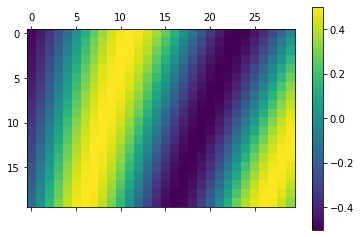

In [43]:
plt.matshow(delta_g.real[0])
plt.colorbar()

In [44]:
ants = np.arange(Nants)
antpairs = []
for i in range(len(ants)):
    for j in range(i, len(ants)):
        if i != j:
            # Exclude autos
            antpairs.append((i,j))
ant_pos = {ant: [14.7*(ant % 5) + 0.5*14.7*(ant // 5),
                 14.7*(ant // 5),
                 0.] for ant in ants} # hexagon-like packing
ants1, ants2 = list(zip(*antpairs))

# Generate random point source locations
# RA goes from [0, 2 pi] and Dec from [-pi, +pi].
ra = np.random.uniform(low=0.4, high=1.4, size=Nptsrc)
dec = np.random.uniform(low=-0.6, high=-0.4, size=Nptsrc) # close to HERA stripe

# Generate fluxes
beta_ptsrc = -2.7
ptsrc_amps = 10.**np.random.uniform(low=-1., high=2., size=Nptsrc)
fluxes = ptsrc_amps[:,np.newaxis] * ((freqs / 100.)**beta_ptsrc)[np.newaxis,:]
print("pstrc amps (input):", ptsrc_amps[:5])

# Beams
beams = [pyuvsim.analyticbeam.AnalyticBeam('gaussian', diameter=14.)
         for ant in ants]

# Run a simulation
t0 = time.time()
_sim_vis = hydra.vis_simulator.simulate_vis(
        ants=ant_pos,
        fluxes=fluxes,
        ra=ra,
        dec=dec,
        freqs=freqs*1e6, # MHz -> Hz
        lsts=times,
        beams=beams,
        polarized=False,
        precision=2,
        use_feed="x",
    )
print("Simulation took %3.2f sec" % (time.time() - t0))

pstrc amps (input): [73.330519    0.1020356  69.87976485  0.62568342 28.14435084]
Simulation took 0.21 sec


In [45]:
# Allocate computed visibilities to only the requested baselines (saves memory)
model0 = hydra.extract_vis_from_sim(ants, antpairs, _sim_vis)
del _sim_vis # save some memory

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

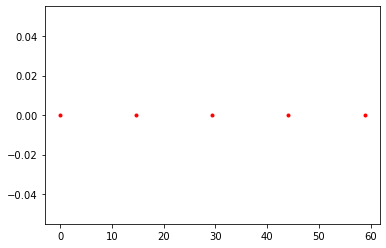

In [46]:
for ant in ants:
    x,y,z = ant_pos[ant]
    plt.plot(x, y, 'r.')
antpairs

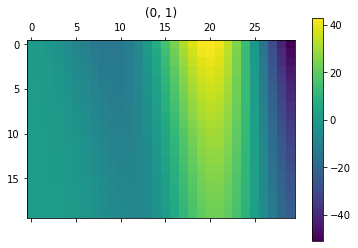

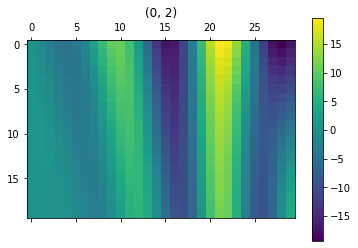

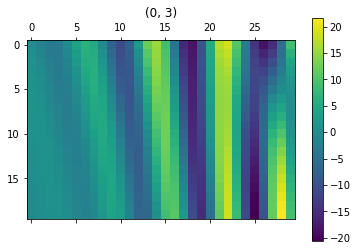

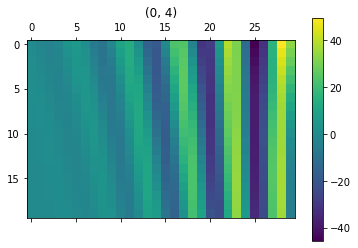

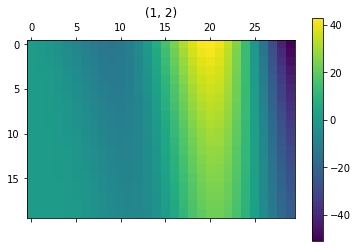

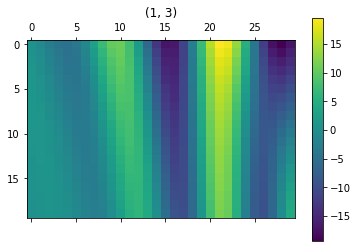

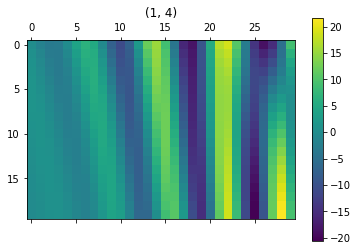

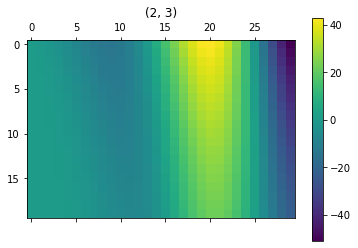

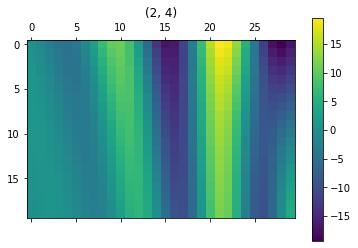

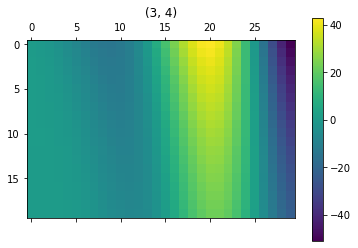

In [47]:
for i in range(model0.shape[0]):
    plt.matshow(model0[i].imag)
    plt.title("%s" % str(antpairs[i]))
    plt.colorbar()
    plt.show()

In [51]:
# Define gains and gain perturbations
gains = (1.1 + 0.1j) * np.ones((Nants, Nfreqs, Ntimes), dtype=model0.dtype)
delta_g = np.array([0.05*np.sin(times[np.newaxis,:] \
                                 * freqs[:,np.newaxis]/100.)
                    for ant in ants])
data = model0.copy()
hydra.apply_gains(data, gains * (1. + delta_g), ants, antpairs, inline=True)
pass

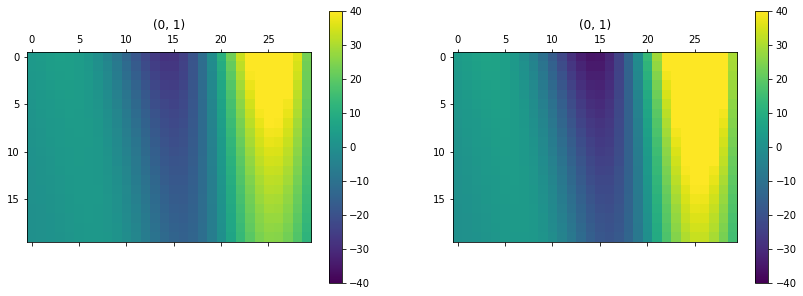

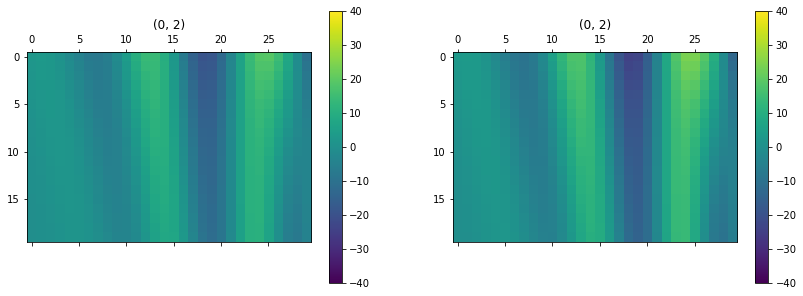

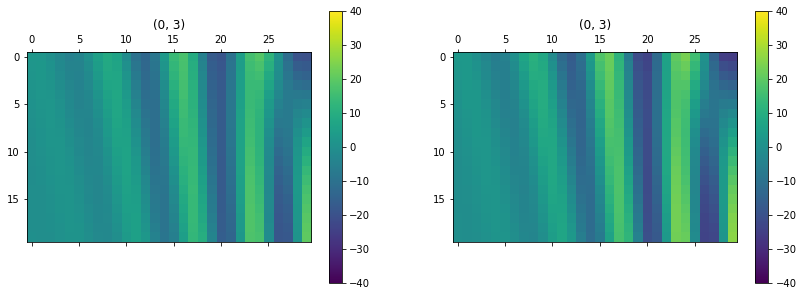

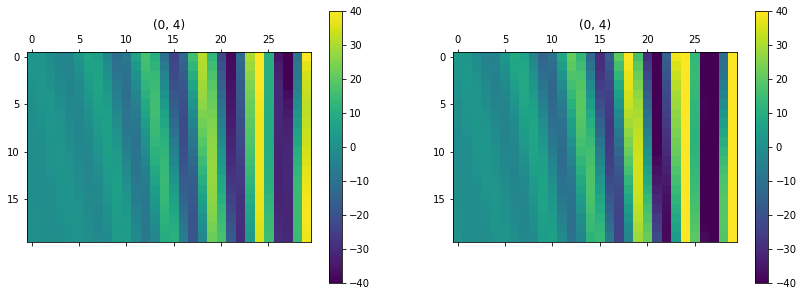

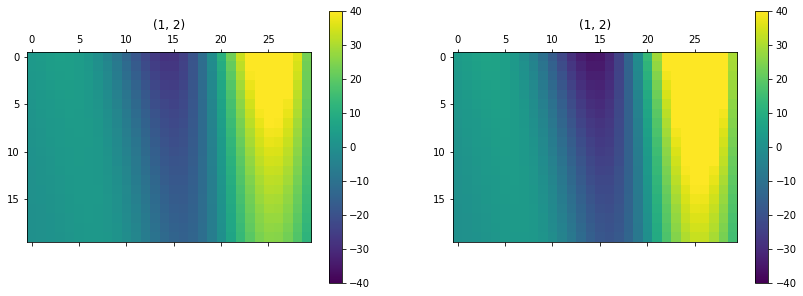

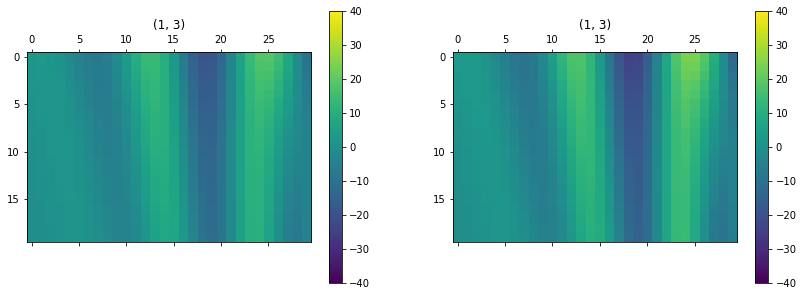

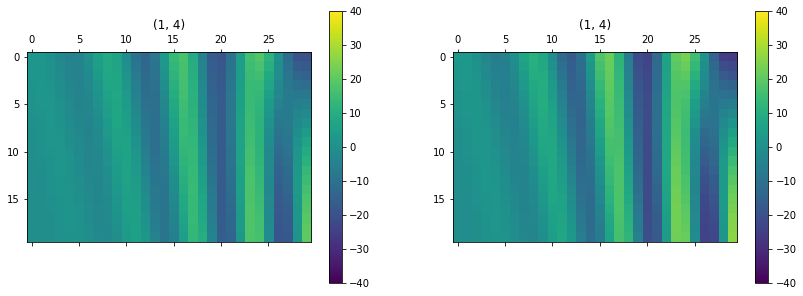

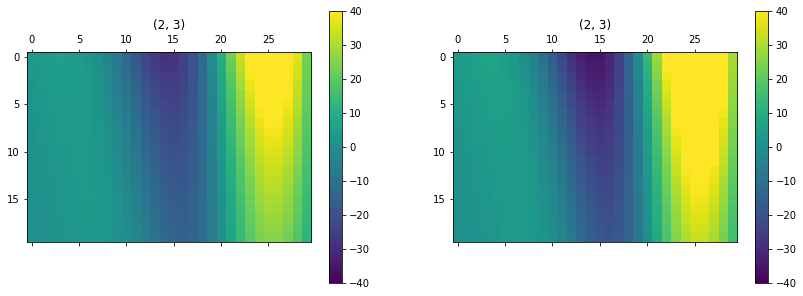

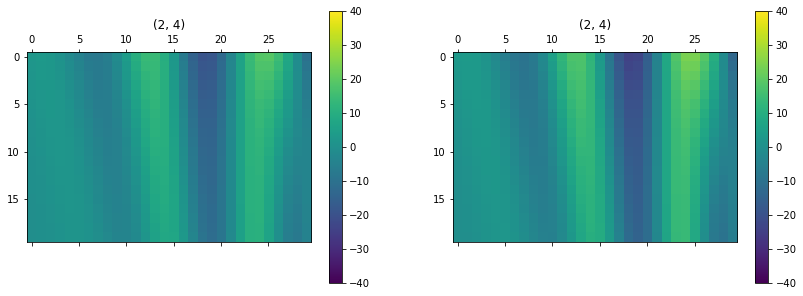

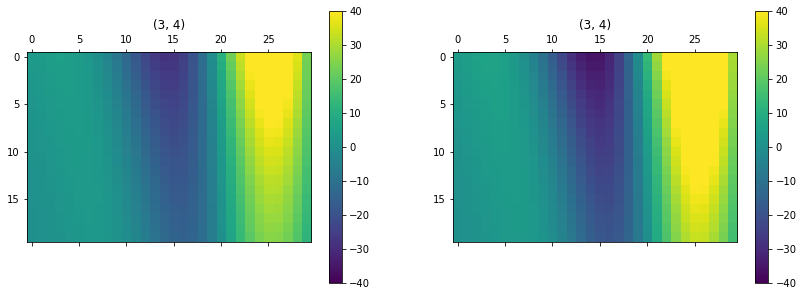

In [60]:
for i in range(model0.shape[0]):
    plt.subplot(121)
    plt.matshow(model0[i].real, fignum=False, vmin=-40., vmax=40.)
    plt.title("%s" % str(antpairs[i]))
    plt.colorbar()
    
    plt.subplot(122)
    plt.matshow(data[i].real, fignum=False, vmin=-40., vmax=40.)
    plt.title("%s" % str(antpairs[i]))
    plt.colorbar()
    
    plt.gcf().set_size_inches((14., 5.))
    plt.show()

In [37]:
# Add noise
data += np.sqrt(0.5) * (  1.0 * np.random.randn(*data.shape) \
                        + 1.j * np.random.randn(*data.shape))

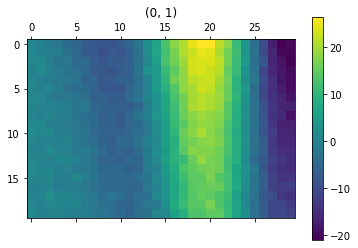

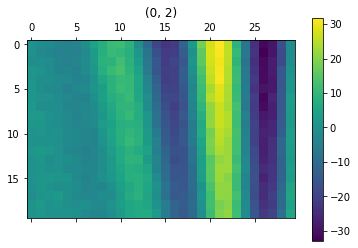

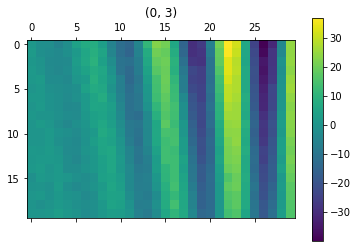

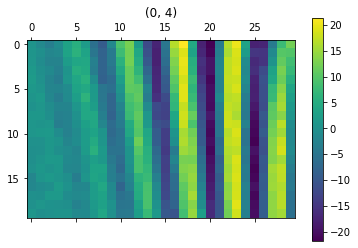

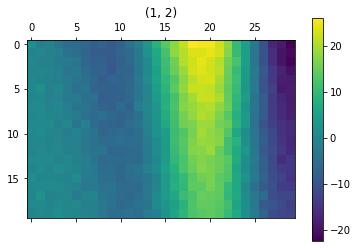

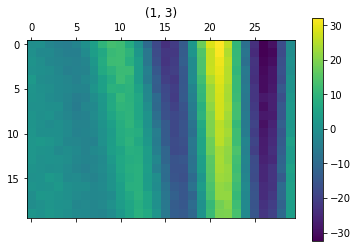

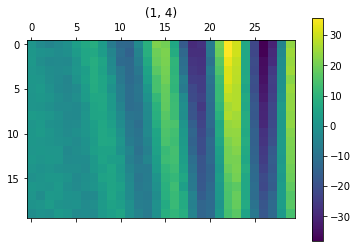

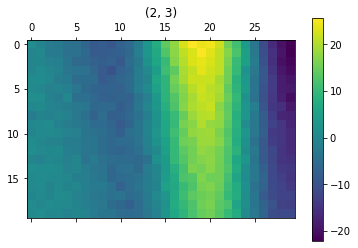

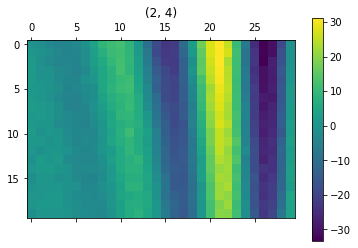

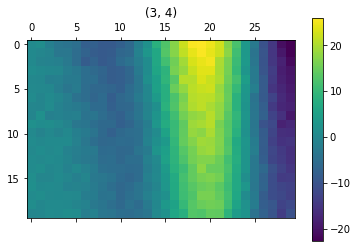

In [38]:
for i in range(model0.shape[0]):
    plt.matshow(data[i].imag)
    plt.title("%s" % str(antpairs[i]))
    plt.colorbar()
    plt.show()

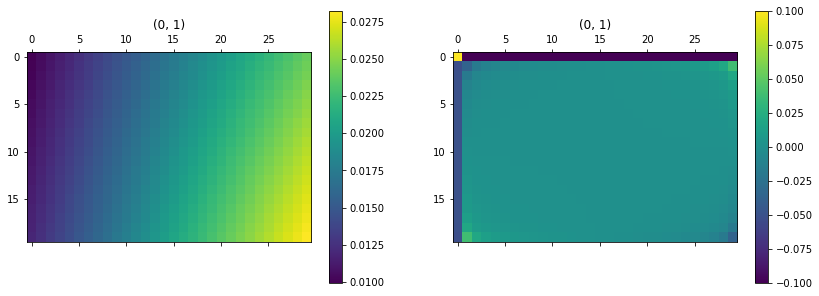

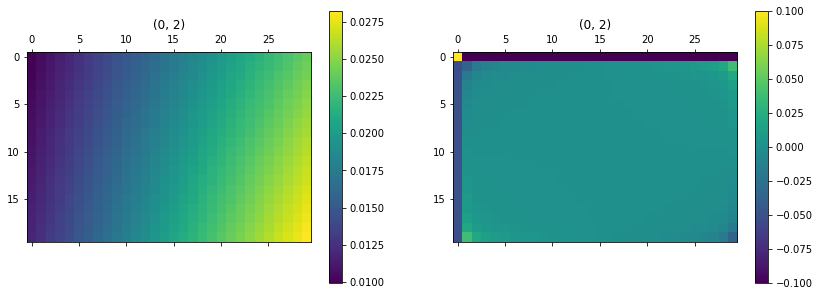

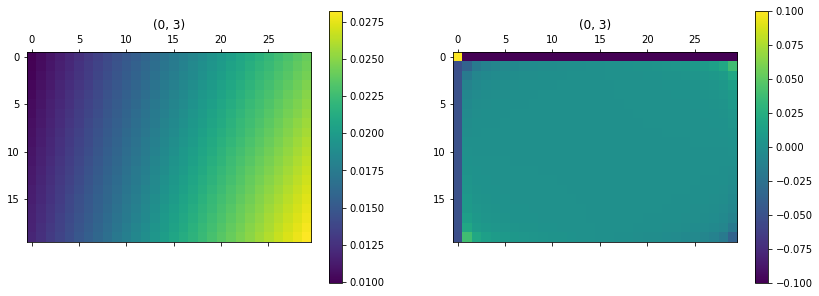

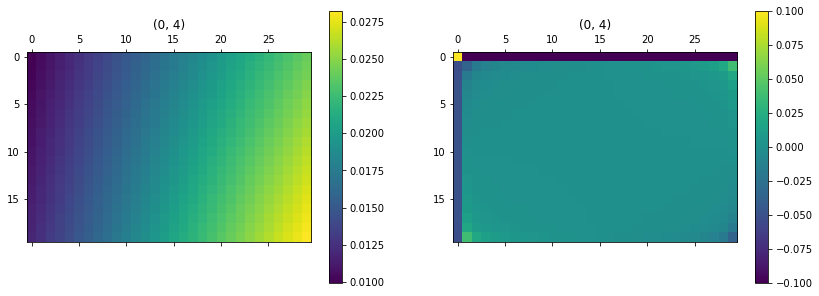

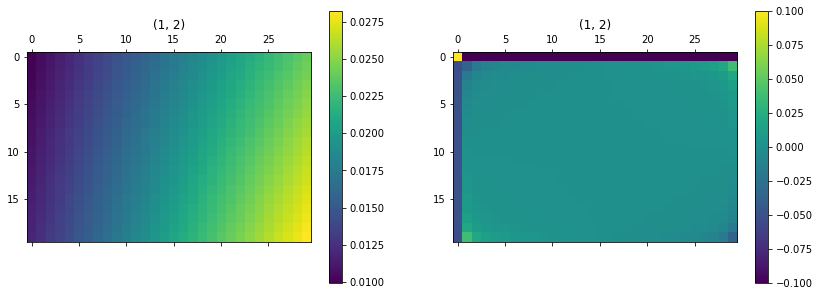

In [63]:
for i in range(delta_g.shape[0]):
    plt.subplot(121)
    plt.matshow(delta_g[i].real, fignum=False) #, vmin=-40., vmax=40.)
    plt.title("%s" % str(antpairs[i]))
    plt.colorbar()
    
    plt.subplot(122)
    plt.matshow(np.fft.fft2(delta_g[i]).real, fignum=False, vmin=-0.1, vmax=0.1) #, vmin=-40., vmax=40.)
    plt.title("%s" % str(antpairs[i]))
    plt.colorbar()
    
    plt.gcf().set_size_inches((14., 5.))
    plt.show()

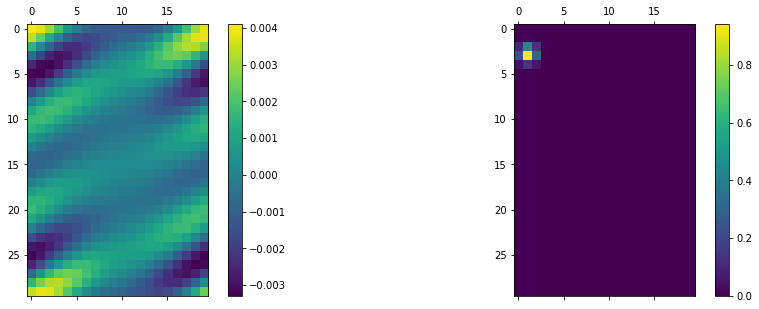

In [91]:
# Generate gain fluctuations from FFT basis
frate = np.fft.fftfreq(times.size, d=times[1] - times[0])
tau = np.fft.fftfreq(freqs.size, d=freqs[1] - freqs[0])

dg = np.fft.ifft2(np.exp(-0.5 * (((frate[:,np.newaxis]-9.)/2.)**2. + ((tau[np.newaxis,:] - 0.05)/0.03)**2.)))

plt.subplot(121)
plt.matshow(dg.real, fignum=False)
plt.colorbar()

plt.subplot(122)
plt.matshow(np.fft.fft2(dg).real, fignum=False)
plt.colorbar()

plt.gcf().set_size_inches((16., 5.))

In [83]:
frate

array([  0.        ,   3.22222222,   6.44444444,   9.66666667,
        12.88888889,  16.11111111,  19.33333333,  22.55555556,
        25.77777778,  29.        ,  32.22222222,  35.44444444,
        38.66666667,  41.88888889,  45.11111111, -48.33333333,
       -45.11111111, -41.88888889, -38.66666667, -35.44444444,
       -32.22222222, -29.        , -25.77777778, -22.55555556,
       -19.33333333, -16.11111111, -12.88888889,  -9.66666667,
        -6.44444444,  -3.22222222])